## Ejercicio 4

In [52]:
from qiskit import IBMQ

provider = IBMQ.load_account()

### Qiskit - QFT

Al igual que en el ejercicio 3, vamos a crear una función que nos devuelva un circuito para la QFT, y otra que nos devuelva la parte intermedia del sumador de Draper:

In [57]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from math import pi

def QFT(circuit, N):

    for i in range(N):
        circuit.h(i)
        for j in range(i + 1, N):
            circuit.crz(pi*0.5**(j-i), j, i)

def adder(circuit, N):
    
    for i in range(N):
        for j in range(i, N):
            circuit.crz(pi*0.5**(j-i), N + j, i)

Inicializamos los qubits operando al valor que queremos.

In [58]:
a_ini = 0b011 # Primer operando: 3
b_ini = 0b010  # Segundo operando: 2

N = 3 # Número de qubits por operando.

# Qubits operando
A = QuantumRegister(N, name='a')        
B = QuantumRegister(N, name='b')

# Registro clásico donde mediremos el resultado.
C = ClassicalRegister(N, name='c')

init_circuit = QuantumCircuit(A, B, C)

# Inicializamos los qubits opreando al valor que deseamos.
for i in range(N):
    
    if ((a_ini >> N - i - 1) & 0x1) == 1:
        init_circuit.x(A[i])

    if (b_ini >> N - i - 1 & 0x1) == 1:
        init_circuit.x(B[i])
        
# init_circuit.barrier()

Ahora, creamos un circuito que implemente por completo el sumador de Draper.

In [59]:
from qiskit import QuantumRegister, ClassicalRegister


circ = QuantumCircuit(A, B, C)

# Hacemos la QFT del primer operando.
QFT(circ, N)

qft_inv = circ.inverse()
# circ.barrier()

adder(circ, N)
# circ.barrier()

circ.compose(qft_inv, inplace=True)
# circ.barrier()
# ????
for i in range(N):
    circ.measure(A[i], C[N - i - 1])

Combinamos el circuito de inicialización con el del sumador:

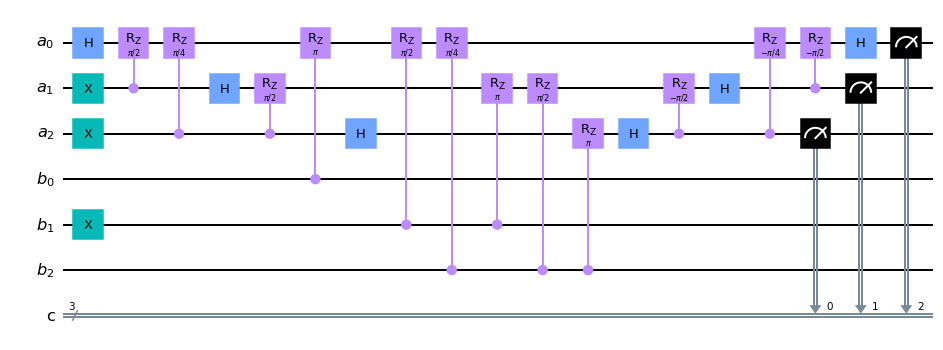

In [60]:
sumador = init_circuit.compose(circ)
sumador.draw(output='mpl', fold=-1)

Antes de lanzar el circuito a un backend real, vamos a probar primero con el simulador local si funciona correctamente:

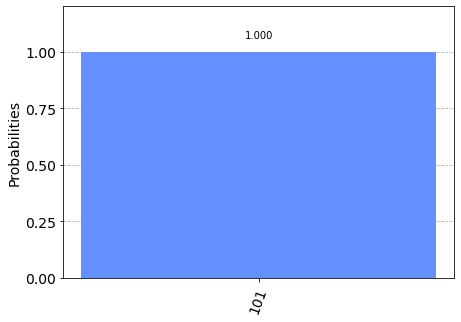

In [61]:
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram

simulator = Aer.get_backend('qasm_simulator')

# Ejectuamos la simulación con ruido
job = execute(sumador, simulator, shots=1000)
counts = job.result().get_counts()

plot_histogram(counts)

Vemos que al sumar 3+2, obtenemos el resultado correcto el 100% de las ejecuciones, por lo que el circuito funciona correctamente.

Vamos a ejectuar ahora el circuito en un backend real. Escogemos el *ibm_perth*, que es el que tiene mayor volumen cuántico de todos los computadores de 7 qubits que disponemos.

Primero transpilamos el circuito para este backend, y luego lanzamos el trabajo.

In [54]:
from qiskit import transpile

backend = provider.get_backend('ibm_perth')
transpiled = transpile(sumador, backend=backend)

job = backend.run(transpiled)
print('Job ID:', job.job_id())

Job ID: 6239be428293e902ca1e5276


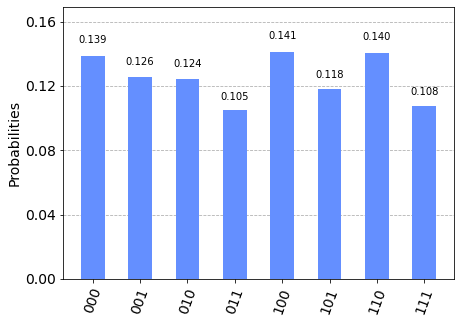

In [71]:
from qiskit.visualization import plot_histogram

result = backend.retrieve_job('62398c51d97bffb1c3693b9a').result().get_counts() # Perth1
# result = backend.retrieve_job('6239bd97ecc41386fbb70cc5').result().get_counts() # Lagos
# result = backend.retrieve_job('6239be428293e902ca1e5276').result().get_counts() # Perth2
plot_histogram(result)

Tras probar varias ejecuciones, no he conseguido obtener ningún resultado coherente con el sumador.

Es probable que la profunidad del circuito transpilado sea demasiado grande, y el ruido afecte demasiado a los cálculos como para poder obtener un resultado coherente. (Las pruebas las realicé quitando las barreras)


### Qiskit- AQFT

Vamos a definir una función para crear el circuito de la AQFT. Como la parte intermedia del circuito no cambia, podemos usar la misma función de antes

In [41]:
def AQFT(circuit, N, n_rot=2):

    for i in range(N):
        circuit.h(i)
        for j in range(i + 1, min(i+n_rot+1, N)):
            circuit.crz(pi*0.5**(j-i), j, i)

Como antes, inicializamos los qubits a los valores que queremos sumar.

In [39]:
a_ini = 0b010  # Primer operando: 2
b_ini = 0b011   # Segundo operando: 3

N = 3 # Número de qubits por operando.

# Qubits operando
A = QuantumRegister(N, name='a')        
B = QuantumRegister(N, name='b')

# Registro clásico donde mediremos el resultado.
C = ClassicalRegister(N, name='c')

init_circuit = QuantumCircuit(A, B, C)

# Inicializamos los qubits opreando al valor que deseamos.
for i in range(N):
    
    if ((a_ini >> N - i - 1) & 0x1) == 1:
        init_circuit.x(A[i])

    if (b_ini >> N - i - 1 & 0x1) == 1:
        init_circuit.x(B[i])

init_circuit.barrier()

Ahora creamos el resto del circuito.

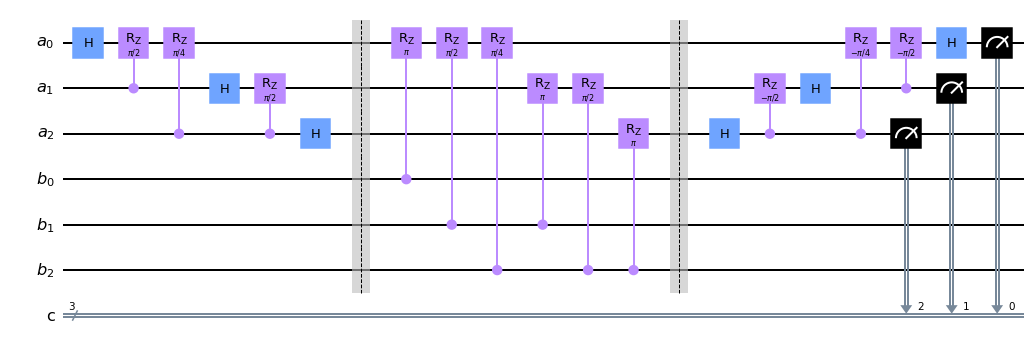

In [42]:
from qiskit import QuantumRegister, ClassicalRegister

circ = QuantumCircuit(A, B, C)

# Hacemos la QFT del primer operando.
AQFT(circ, N, n_rot=2)
inv = circ.inverse()

circ.barrier()

adder(circ, N)
circ.barrier()

circ.compose(inv, inplace=True)

circ.measure(A, C)
circ.draw(output='mpl', fold=-1)

Vemos que, como usamos 3 qubits, y el número de rotaciones de lq AQFT es 2, el circuito es idéntico al de la QFT.

Unimos los circuito de inicialicación y el del sumador.

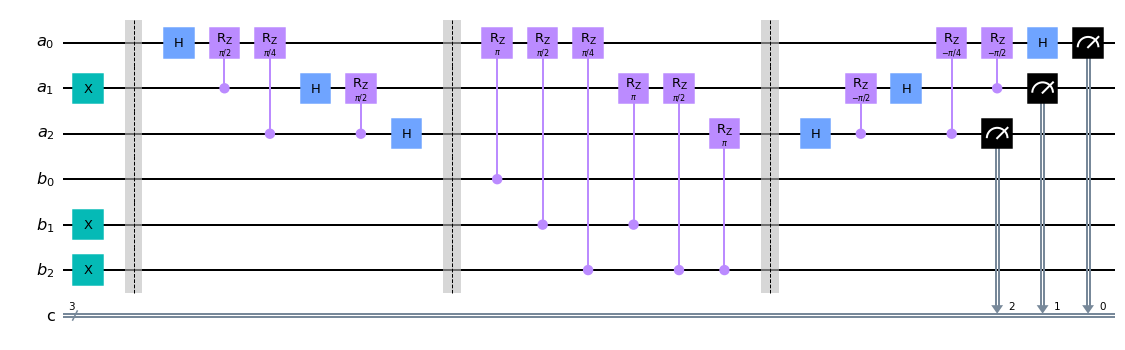

In [43]:
sumador_aqft = init_circuit.compose(circ)
sumador_aqft.draw(output='mpl', fold=-1)

Transpilamos y ejecutamos el circuito en el ibmq_jakarta.

In [97]:
backend = provider.get_backend('ibmq_jakarta')

transpiled = transpile(sumador_aqft, backend)

job = backend.run(transpiled)
print('Job ID:', job.job_id())

Job ID: 6238d6ae0af65d12cad9263a


Recogemos los resultados y los dibujamos.

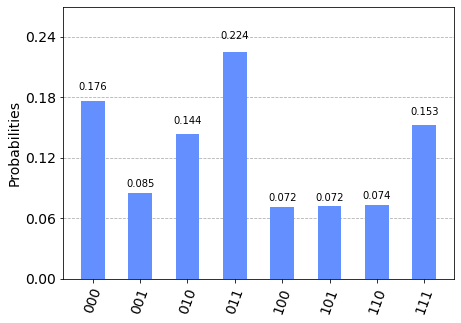

In [24]:
from qiskit.visualization import plot_histogram


result = backend.retrieve_job('6238d6ae0af65d12cad9263a').result().get_counts()
plot_histogram(result)

Como el circuito es idéntico al de la QFT (por estar usando tres qubits y dos rotaciones máximas), los resultados presentan el mismo alto nivel de ruido.

### Braket - QFT

In [38]:
import matplotlib.pyplot as plt

def plot_histogram2(result: dict, width=5) -> None:
    
    counts = sorted(result.items(), key=lambda x: x[0])
    
    keys = [str(x[0]) for x in counts]
    values = [x[1] for x in counts]

    plt.figure(figsize=(width, 5))
    plt.bar_label(plt.bar(keys, [x / 1000 for x in values]), values)

Definimos nuestra función para la QFT, la parte intermedia del sumador, y la QFT inversa (No he encontrado nada para calcular la inversa de un circuito automáticamente con Braket).

In [42]:
from braket.circuits import Circuit

from math import pi

def QFT(circuit: Circuit, N):
    
    for i in range(N):
        circuit.h(i)
        for j in range(i + 1, N):
            circuit.cphaseshift(j, i, pi*0.5**(j-i))

def adder(circuit, N):
    for i in range(N):
        for j in range(i, N):
            circuit.cphaseshift(N + j, i, pi*0.5**(j-i))

def IQFT(circuit, N):
    
    for i in reversed(range(N)):    
         
        for j in reversed(range(i + 1, N)):
            circuit.cphaseshift(j, i, -pi*0.5**(j-i))
        circuit.h(i)         

Definimos una función para darle el varor inicial deseado a los qubits.

In [43]:
def init_qubits(circuit, A, B,  N):

    # Inicializamos los qubits opreando al valor que deseamos.
    for i in range(N):
        
        if ((A >> N - i - 1) & 0x1) == 1:
            circuit.x(i)

        if (B >> N - i - 1 & 0x1) == 1:
            circuit.x(N + i)

Usando estas funciones podemos crear el circuito entero del sumador de Draper:

In [48]:
N = 4

aspen_circ = Circuit()

A = 0b0101 # 5
B = 0b0100 # 4

# # Inicializamos los qubits.
init_qubits(aspen_circ, A, B, N)

# Añadimos la QFT al primer operando
QFT(aspen_circ, N)

# # Añadimos la parte intermedia del sumador
adder(aspen_circ, N)

# Deshacemos la QFT del primer operando.
IQFT(aspen_circ, N)

Probamos el circuito primero con un simulador local.

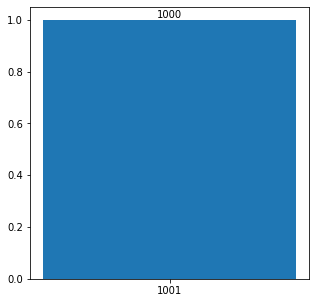

In [49]:
from braket.devices import LocalSimulator
from collections import Counter

sim = LocalSimulator()
measurements = sim.run(aspen_circ, shots=1000).result().measurements

# Nos quedamos solo con las mediciones de los primero 4 qubits.
results = Counter([''.join(str(i) for i in x[:4]) for x in measurements])
plot_histogram2(results)

Al sumar 3+5, obtenemos 8 el 100% de las ejecuciones, por lo que el circuito funciona correctamente.

Una vez probado el circuito, vamos a lanzar el código al Aspen-11.

In [50]:
from braket.circuits import Circuit
from braket.aws import AwsDevice

# Necesitamos configurar la región a us-west-1
device = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-1")
s3_folder = ("amazon-braket-f085dc433a90", "apcc2022/JulianCamara/Rigetti")

task = device.run(aspen_circ, s3_folder)
print("Task:",task.id)
print("Status:", task.state())

Task: arn:aws:braket:us-west-1:975085098040:quantum-task/c5c581a0-ce17-4332-9c66-edadaf9e6e55
Status: CREATED


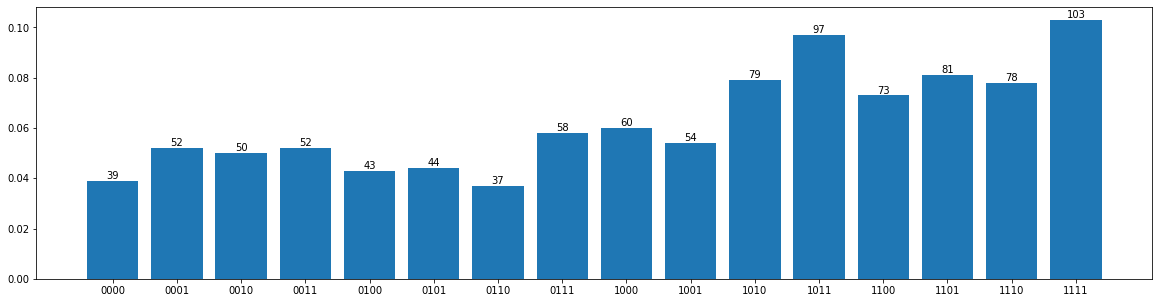

In [51]:
from collections import Counter
from braket.aws import AwsQuantumTask


task = AwsQuantumTask(arn="arn:aws:braket:us-west-1:975085098040:quantum-task/b788ebcd-3e00-467b-8eb1-38be08149aff")

results = Counter([''.join(str(i) for i in x[:4]) for x in task.result().measurements])
plot_histogram2(results, width=20)

## Braket - AQFT

Como el computador de IonQ no soporta puertas Z controladas, vamos a crear la nuestra propia.

In [1]:
from math import pi
from braket.circuits import Circuit

def cRz(circ: Circuit, q0, q1, theta):

    circ.rz(q1, theta/2).cnot(q0, q1).rz(q1, -1.0*theta/2).cnot(q0, q1)

my_crz = Circuit()
cRz(my_crz, 1, 0, pi)
print(my_crz)

T  : |   0    |1|    2    |3|
                             
q0 : -Rz(1.57)-X-Rz(-1.57)-X-
               |           | 
q1 : ----------C-----------C-

T  : |   0    |1|    2    |3|


Para crear la puerta primero aplicamos una rotación de Θ/2 radianes al qubit objetivo (q0). Luego, dependiendo del bquit de control (q1) pueden suceder dos cosas:

- Si q1 = 0, entonces se aplicará una rotación de -Θ/2 radianes a q0, por lo que este se quedará como estaba al principio.
- Si q1 = 1, entonces las CNOT invertirán el signo de la segunda rotación, por lo que q0 rotará un total de Θ/2 + Θ/2 = Θ radianes.

Ahora re-definimos las funciones de la QFT y la AQFT para que usen estas puertas.

In [2]:
from braket.circuits import Circuit

from math import pi

def AQFT(circuit: Circuit, N, n_rot=2):
    
    for i in range(N):
        circuit.h(i)
        for j in range(i + 1, min(i+n_rot+1, N)):
            cRz(circuit, j, i, theta=pi*0.5**(j-i))

def adder2(circuit, N):
    for i in range(N):
        for j in range(i, N):
            cRz(circuit, N + j, i, theta=pi*0.5**(j-i))

def IAQFT(circuit, N, n_rot=2):
    
    for i in reversed(range(N)):    
         
        for j in reversed(range(i + 1, min(i+n_rot+1, N))):
            cRz(circuit, j, i, theta=-pi*0.5**(j-i))
        circuit.h(i)   

Usamos la misma función que antes para inicializar los qubits operando.

In [3]:
def init_qubits(circuit, A, B,  N):

    # Inicializamos los qubits opreando al valor que deseamos.
    for i in range(N):
        
        if ((A >> N - i - 1) & 0x1) == 1:
            circuit.x(i)

        if (B >> N - i - 1 & 0x1) == 1:
            circuit.x(N + i)

Ahora creamos el circuito completo del sumador. En este caso vamos a sumar 5 + 4.

In [26]:
from braket.circuits import Circuit

# Número de qubits por operando.
N = 4 

# Operandos
A = 0b0101 # 5
B = 0b0100 # 4

ionQ_circ = Circuit()
init_qubits(ionQ_circ, A, B, N)


AQFT(ionQ_circ, N, n_rot=2)
adder2(ionQ_circ, N)
IAQFT(ionQ_circ, N, n_rot=2)


Probamos el circuito en el simulador local primero.

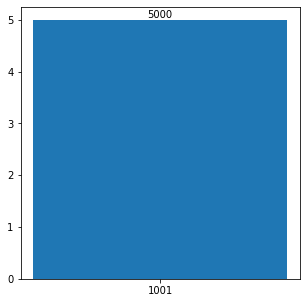

In [54]:
from braket.devices import LocalSimulator
from collections import Counter

from collections import Counter

results = LocalSimulator().run(ionQ_circ, shots=5000).result()

## Se muestran los resultados.
counts = Counter([''.join(str(i) for i in x[:N]) for x in results.measurements])
plot_histogram2(counts)

Vemos que el circuito ha funcionado correctamente. Resulta curioso que a pesar de usar la AQFT, no hayamos medido ningún resultado erróneo ninguna vez.

Ahora vamos a lanzarlo al backend de IonQ.

In [29]:
import boto3
from braket.circuits import Circuit
from braket.aws import AwsDevice

device = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")
s3_folder = ("amazon-braket-f085dc433a90", "apcc2022/JulianCamara/IonQ")


task = device.run(ionQ_circ, s3_folder)
print("Task:",task.id)
print("Status:", task.state())

Task: arn:aws:braket:us-east-1:975085098040:quantum-task/134c8df4-017f-43ff-8ac0-dfc9f4ec0c65
Status: CREATED


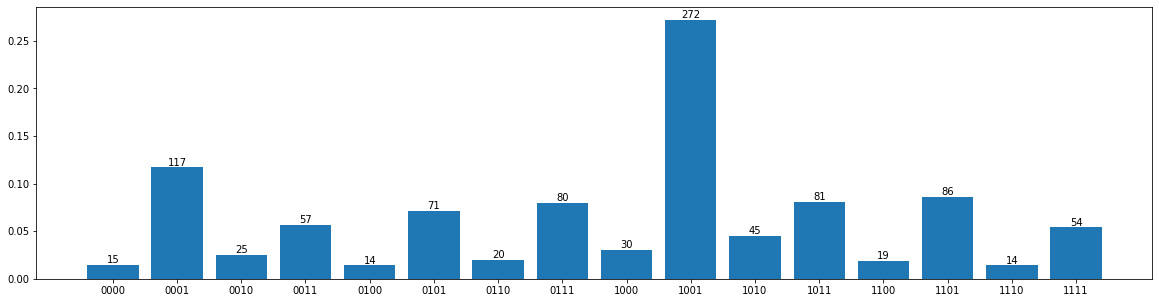

In [41]:
from braket.aws import AwsQuantumTask

task = AwsQuantumTask(arn="arn:aws:braket:us-east-1:975085098040:quantum-task/134c8df4-017f-43ff-8ac0-dfc9f4ec0c65")

results = Counter([''.join(str(i) for i in x[:4]) for x in task.result().measurements])
plot_histogram2(results, width=20)

Vemos que, por primera vez, los resultados salen correctamente, y se distingue bien el resultado correcto (*1001*) de los erróneos. (Al igual que en la práctica 2, parece que el computador de IonQ es el que presenta un menor nivel de ruido en los resultados).

Al usar la AQFT, el circuito resultante es menos profundo, por lo que es menos propenso a errores. Sin embargo, como vimos en el ejercicio3, también existe una pequeña posibilidad de medir un resultado incorrecto aunque no haya habido errores debidos al ruido.